In [1]:
# %load_ext autoreload
# %autoreload 2
%matplotlib notebook

In [2]:
import os
import sys
import torch
import math
import itertools
from collections import defaultdict
sys.path.append(os.path.abspath(os.path.join('..')))
import cv2
import numpy as np
from plenoxels.models.lowrank_video import LowrankVideo
from plenoxels.models.density_fields import TriplaneDensityField
from plenoxels.models.lowrank_appearance import LowrankAppearance
from plenoxels.datasets.photo_tourism import PhotoTourismDataset
from plenoxels.datasets.video_datasets import Video360Dataset
from plenoxels.ops.image import metrics
from plenoxels.models.utils import grid_sample_wrapper, compute_plane_tv, compute_line_tv, raw2alpha
import matplotlib.pyplot as plt

In [31]:
def eval_step(data, model, batch_size=4096):
    """
    Note that here `data` contains a whole image. we need to split it up before tracing
    for memory constraints.
    """
    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=True):
            rays_o = data["rays_o"]
            rays_d = data["rays_d"]
            near_far = data["near_far"]
            timestamp = data["timestamps"]

            preds = defaultdict(list)
            for b in range(math.ceil(rays_o.shape[0] / batch_size)):
                rays_o_b = rays_o[b * batch_size: (b + 1) * batch_size].contiguous().cuda()
                rays_d_b = rays_d[b * batch_size: (b + 1) * batch_size].contiguous().cuda()
                timestamps_b = timestamp[b * batch_size: (b + 1) * batch_size].contiguous().cuda()
                near_far_b = near_far[b * batch_size: (b + 1) * batch_size].contiguous().cuda()

                outputs = model(
                    rays_o_b, rays_d_b, timestamps_b, near_far=near_far_b,
                    channels={"rgb", "depth"}, 
                    bg_color=torch.tensor([1.0]*3).cuda(), 
                )
                for k, v in outputs.items():
                    if not isinstance(v, list):
                        preds[k].append(v.cpu())
        return {k: torch.cat(v, 0) for k, v in preds.items()}

#### Load video poses and near-fars

In [4]:
from plenoxels.datasets.video_datasets import load_llffvideo_poses

In [5]:
datadir = "/data/DATASETS/VidNerf/flame_salmon"
downsample = 2.0
split = 'train'
per_cam_poses, per_cam_near_fars, intrinsics, videopaths = load_llffvideo_poses(
    datadir, downsample=downsample, split=split, near_scaling=1.0)

In [6]:
per_cam_poses.shape

torch.Size([18, 3, 4])

In [7]:
per_cam_near_fars.shape

torch.Size([18, 2])

#### Generate spiral poses, rays and near-fars

In [8]:
from plenoxels.datasets.ray_utils import gen_camera_dirs

In [23]:
def normalize(v):
    """Normalize a vector."""
    return v / np.linalg.norm(v)

def average_poses(poses):
    """
    Calculate the average pose, which is then used to center all poses
    using @center_poses. Its computation is as follows:
    1. Compute the center: the average of pose centers.
    2. Compute the z axis: the normalized average z axis.
    3. Compute axis y': the average y axis.
    4. Compute x' = y' cross product z, then normalize it as the x axis.
    5. Compute the y axis: z cross product x.

    Note that at step 3, we cannot directly use y' as y axis since it's
    not necessarily orthogonal to z axis. We need to pass from x to y.
    Inputs:
        poses: (N_images, 3, 4)
    Outputs:
        pose_avg: (3, 4) the average pose
    """
    # 1. Compute the center
    center = poses[..., 3].mean(0)  # (3)
    # 2. Compute the z axis
    z = normalize(poses[..., 2].mean(0))  # (3)
    # 3. Compute axis y' (no need to normalize as it's not the final output)
    y_ = poses[..., 1].mean(0)  # (3)
    # 4. Compute the x axis
    x = normalize(np.cross(z, y_))  # (3)
    # 5. Compute the y axis (as z and x are normalized, y is already of norm 1)
    y = np.cross(x, z)  # (3)

    pose_avg = np.stack([x, y, z, center], 1)  # (3, 4)

    return pose_avg

def viewmatrix(z, up, pos):
    vec2 = normalize(z)
    vec1_avg = up
    vec0 = normalize(np.cross(vec1_avg, vec2))
    vec1 = normalize(np.cross(vec2, vec0))
    return np.stack([-vec0, vec1, vec2, pos], axis=1)

def generate_spiral_path(poses: np.ndarray, 
                         near_fars: np.ndarray, 
                         n_frames=120, 
                         n_rots=2, 
                         zrate=.5) -> torch.Tensor:
    # center pose
    c2w = average_poses(poses)  # [3, 4]

    # Get average pose
    up = normalize(poses[:, :3, 1].sum(0))

    # Find a reasonable "focus depth" for this dataset as a weighted average
    # of near and far bounds in disparity space.
    close_depth, inf_depth = near_fars.min() * 0.9, near_fars.max() * 1.0
    dt = 0.75
    focal = 1.0 / (((1.0 - dt) / close_depth + dt / inf_depth))

    # Get radii for spiral path using 90th percentile of camera positions.
    positions = poses[:, :3, 3]
    radii = np.percentile(np.abs(positions), 90, 0)
    radii = np.concatenate([radii, [1.]])

    # Generate poses for spiral path.
    render_poses = []
    cam2world = average_poses(poses)
    for theta in np.linspace(0., 2. * np.pi * n_rots, n_frames, endpoint=False):
        t = radii * [np.cos(theta), -np.sin(theta), -np.sin(theta * zrate), 1.]
        position = c2w @ t
        lookat = c2w @ np.array([0, 0, -focal, 1.0])
        z_axis = normalize(position - lookat)
        render_poses.append(viewmatrix(z_axis, up, position))
    return np.stack(render_poses, axis=0)

In [24]:
spiral_poses = generate_spiral_path(
    poses=per_cam_poses.numpy(),
    near_fars=per_cam_near_fars.numpy(),
    n_frames=3
)
spiral_poses = torch.from_numpy(spiral_poses).float()

In [51]:
c2w

tensor([[-0.9800,  0.0228,  0.1975,  0.7094],
        [ 0.0023,  0.9946, -0.1035, -0.3873],
        [ 0.1988,  0.1010,  0.9748,  0.1882]])

In [55]:
torch.linalg.norm(per_cam_poses.view(per_cam_poses.shape[0], -1) - c2w.view(-1), dim=1).argmin()

tensor(15)

In [59]:
dev = "cpu"
rays_o = []
rays_d = []
timestamps = []
near_fars = []
interp_time = torch.linspace(0, 299, spiral_poses.shape[0], dtype=torch.int)
for pose_id in range(spiral_poses.shape[0]):
    x, y = torch.meshgrid(
        torch.arange(intrinsics.width, device=dev),
        torch.arange(intrinsics.height, device=dev),
        indexing="xy",
    )
    x = x.flatten()
    y = y.flatten()
    camera_dirs = gen_camera_dirs(
        x, y, intrinsics, True)  # [num_rays, 3]
    c2w = spiral_poses[pose_id]  # [3, 4]
    directions = (camera_dirs[:, None, :] * c2w[None, :3, :3]).sum(dim=-1)
    origins = torch.broadcast_to(c2w[None, :3, -1], directions.shape)
    rays_o.append(origins)
    rays_d.append(directions)
    timestamps.append(interp_time[pose_id].repeat(origins.shape[0]))
    # Find the closest cam
    closest_cam_idx = torch.linalg.norm(
        per_cam_poses.view(per_cam_poses.shape[0], -1) - c2w.view(-1), dim=1).argmin()
    near_fars.append(per_cam_near_fars[closest_cam_idx].float().repeat(origins.shape[0], 1))
    
rays_o = torch.cat(rays_o, 0)
rays_d = torch.cat(rays_d, 0)
timestamps = torch.cat(timestamps, 0)
near_fars = torch.cat(near_fars, 0)

In [60]:
data = {
    "rays_o": rays_o,
    "rays_d": rays_d,
    "near_far": near_fars,
    "timestamps": timestamps,
}

#### Initialize model from checkpoint

In [27]:
chk_path = '../logs/salmonvideo/mlp_downsample2_istonly_rank1_higherres/model.pth'
m_data = torch.load(chk_path)

In [28]:
reso = [
    m_data['model']['grids.0.0'].shape[-1],
    m_data['model']['grids.0.0'].shape[-2],
    m_data['model']['grids.0.1'].shape[-2],
    150
]
print("Model resolution: ", reso)

Model resolution:  [120, 90, 100, 150]


In [29]:
model = LowrankVideo(
    aabb=torch.tensor([[-2., -2., -2.], [2., 2., 2.]]),
    len_time=299,
    is_ndc=False,
    is_contracted=True,
    lookup_time=False,
    proposal_sampling=True,
    global_scale=m_data['model']['spatial_distortion.global_scale'],
    global_translation=m_data['model']['spatial_distortion.global_translation'],
    raymarch_type='fixed',
    single_jitter=False,
    n_intersections=48,
    density_activation='trunc_exp',
    use_F=False,
    sh=False,
    density_field_resolution=[128, 256],
    density_field_rank=1,
    num_proposal_samples=[256, 96],
    proposal_feature_dim=10,
    proposal_decoder_type='nn',
    density_model='triplane',
    multiscale_res=[1, 2, 4],
    grid_config=[
        {
            "input_coordinate_dim": 4,
            "output_coordinate_dim": 64,
            "grid_dimensions": 2,
            "resolution": [120, 90, 100, 150],
            "rank": 1,
        }
    ],
)

In [30]:
model.load_state_dict(m_data['model'])
model.cuda();

#### Run

In [61]:
spiral_outputs = eval_step(data, model, batch_size=4096)

In [21]:
image_len = intrinsics.width * intrinsics.height
num_images = spiral_outputs['rgb'].shape[0] // image_len
print("Output contains %d frames" % (num_images, ))

Output contains 3 frames


#### Save to file

In [ ]:
imgs = spiral_outputs['rgb']
frames = imgs.view(num_images, image_len, 3)
frames = frames.view(num_images, intrinsics.height, intrinsics.width, 3)
video = cv2.VideoWriter(
    video_file_name, cv2.VideoWriter_fourcc(*'mp4v'), 30, (intrinsics.width, intrinsics.height)
)
for i in range(num_images):
    frame = frames[i]
    frame = (frame * 255.0).to(torch.uint8).numpy()
    video.write(frame[:, :, ::-1])  # uses BGR convention
cv2.destroyAllWindows()
video.release()


#### Plot

<IPython.core.display.Javascript object>


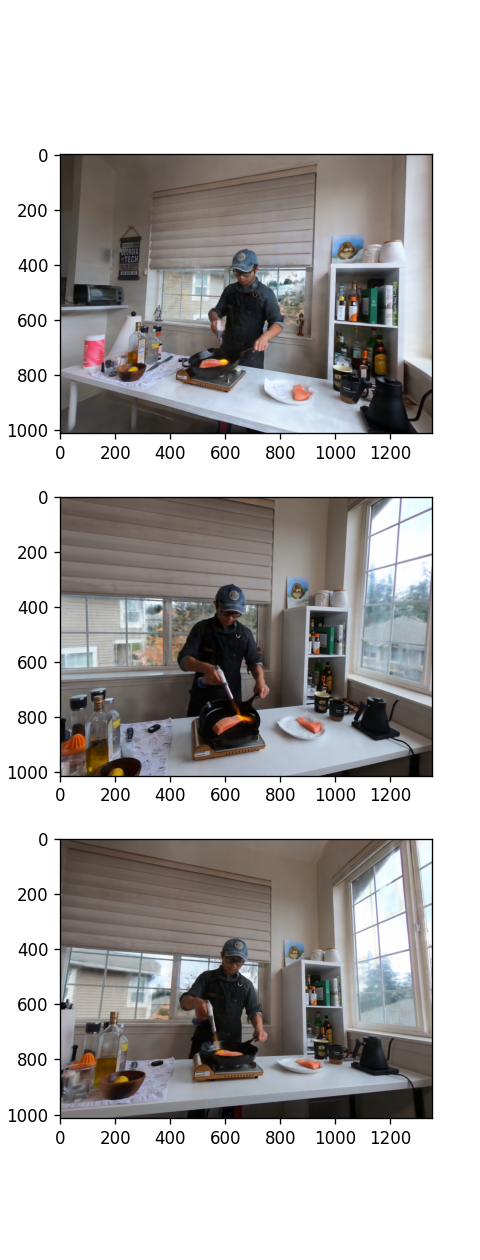

In [62]:
# spiral-path with far multiplied by 1.0, near_far=closest-image
fig, ax = plt.subplots(nrows=num_images, figsize=(4, 3.5*num_images))
for i in range(num_images):
    img = spiral_outputs['rgb'][i * image_len: (i + 1) * image_len].view(intrinsics.height, intrinsics.width, 3)
    ax[i].imshow(img)

<IPython.core.display.Javascript object>


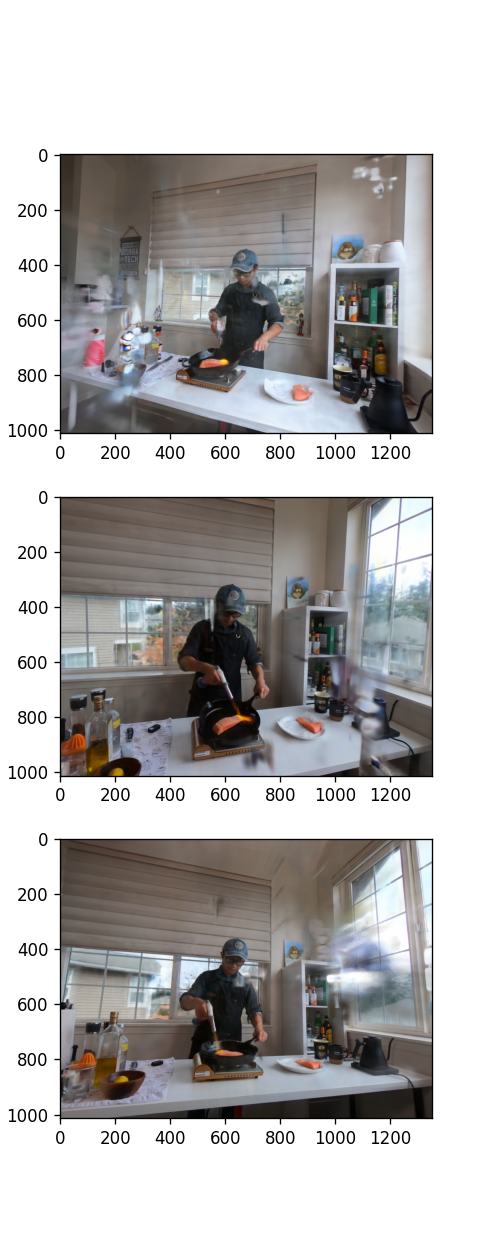

In [50]:
# spiral-path with far multiplied by 1.0, near_far=min,max
fig, ax = plt.subplots(nrows=num_images, figsize=(4, 3.5*num_images))
for i in range(num_images):
    img = spiral_outputs['rgb'][i * image_len: (i + 1) * image_len].view(intrinsics.height, intrinsics.width, 3)
    ax[i].imshow(img)

<IPython.core.display.Javascript object>


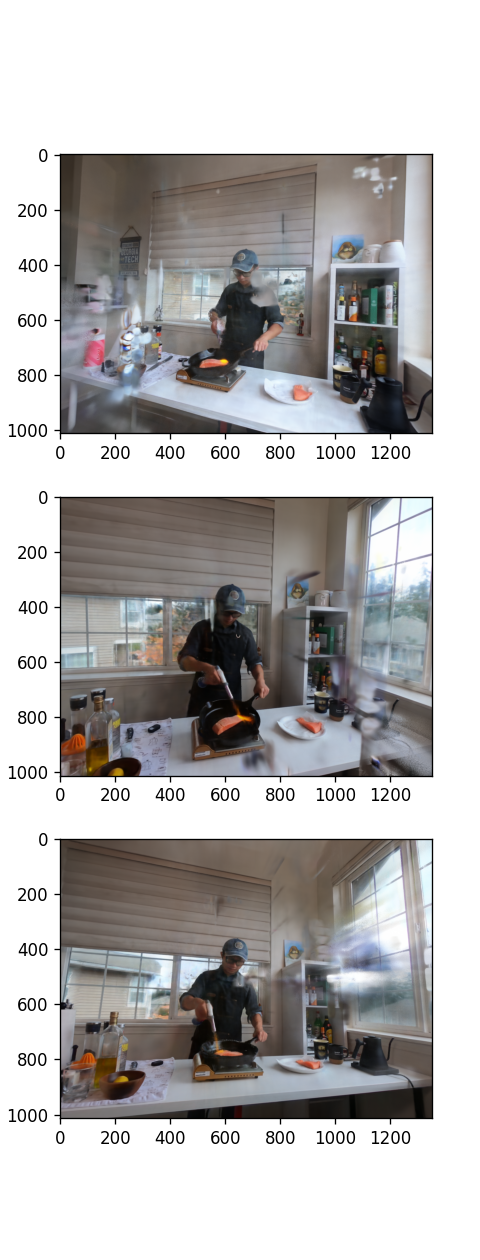

In [41]:
# spiral-path with far multiplied by 1.0, far=66 instead of 33, near=0.9 instead of 1.2
fig, ax = plt.subplots(nrows=num_images, figsize=(4, 3.5*num_images))
for i in range(num_images):
    img = spiral_outputs['rgb'][i * image_len: (i + 1) * image_len].view(intrinsics.height, intrinsics.width, 3)
    ax[i].imshow(img)

<IPython.core.display.Javascript object>


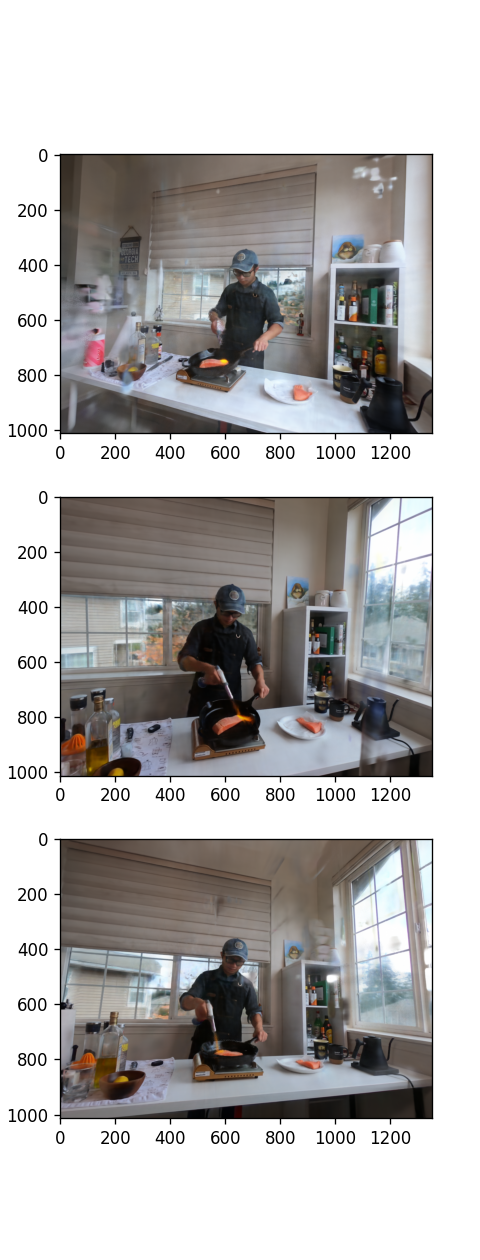

In [37]:
# spiral-path with far multiplied by 1.0, far=66 instead of 33
fig, ax = plt.subplots(nrows=num_images, figsize=(4, 3.5*num_images))
for i in range(num_images):
    img = spiral_outputs['rgb'][i * image_len: (i + 1) * image_len].view(intrinsics.height, intrinsics.width, 3)
    ax[i].imshow(img)

<IPython.core.display.Javascript object>


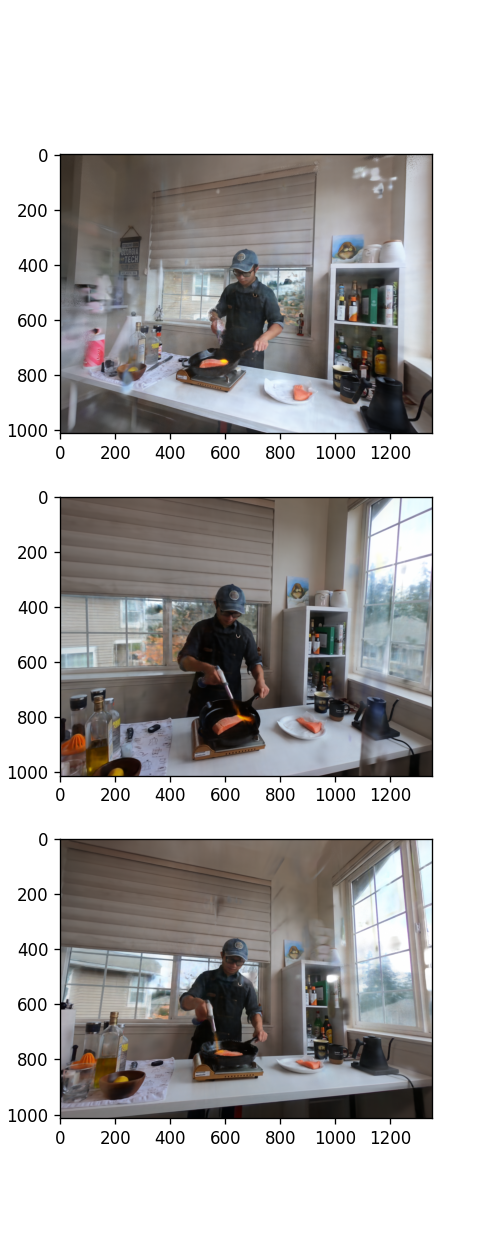

In [33]:
# spiral-path with far multiplied by 1.0
fig, ax = plt.subplots(nrows=num_images, figsize=(4, 3.5*num_images))
for i in range(num_images):
    img = spiral_outputs['rgb'][i * image_len: (i + 1) * image_len].view(intrinsics.height, intrinsics.width, 3)
    ax[i].imshow(img)

<IPython.core.display.Javascript object>


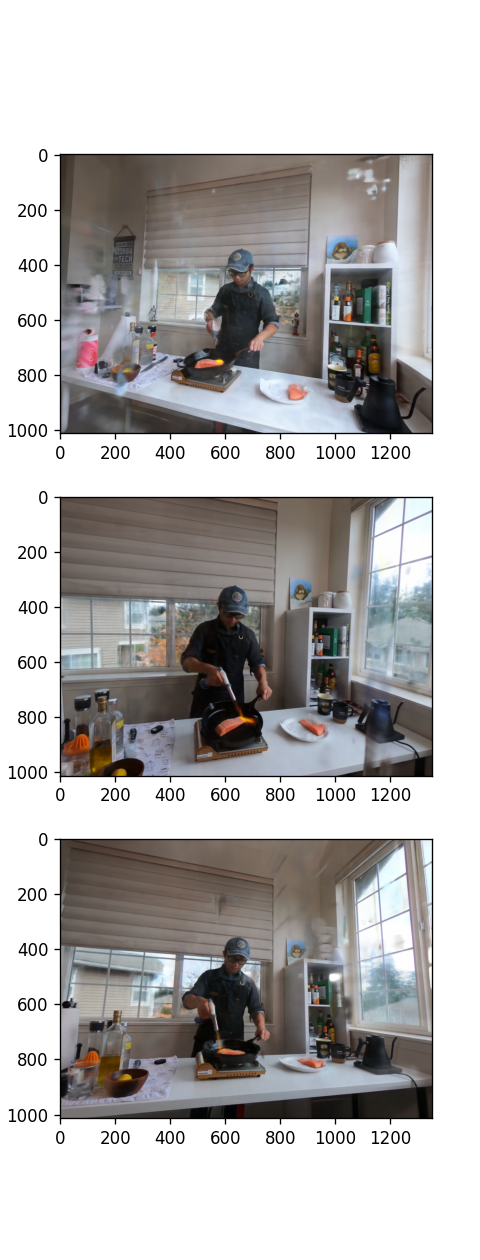

In [22]:
# spiral-path with far multiplied by 5.0
fig, ax = plt.subplots(nrows=num_images, figsize=(4, 3.5*num_images))
for i in range(num_images):
    img = spiral_outputs['rgb'][i * image_len: (i + 1) * image_len].view(intrinsics.height, intrinsics.width, 3)
    ax[i].imshow(img)